In [1]:
import pandas as pd
from datetime import datetime
from functools import reduce
import os
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from datetime import datetime, timedelta
import numpy as np
from matplotlib.lines import Line2D
import mplfinance as mpf
import seaborn as sns

# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
cwd = os.getcwd()  # get current working directory

# Get the parent directory of the current working directory
grandparent_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))

end_date = '2024-04-01'
end_date = datetime.strptime(end_date, '%Y-%m-%d')  # Convert end_date to datetime object
new_date = end_date - timedelta(days=1)  # Subtract 1 day from end_date

new_date_str = new_date.strftime('%Y-%m-%d')  # Convert new_date back to string format

# Load environment variables from .env file
load_dotenv()

# Import environment variables
start_date = os.getenv('start_date')
end_date = os.getenv('end_date')

## Master Data Table - Without Sentiment Data

In [4]:
df_final = pd.read_parquet(os.path.join(grandparent_dir, "data\\processed\\files\\processed_data.parquet.gzip"))

df_final.rename(columns={'value': 'btc_fear_and_greed_index'}, inplace=True)

columns_to_delete = ['BTC_VOLUME', 'value_classification', 'Adj_Close']

# Delete the specified columns
df_final = df_final.drop(columns=columns_to_delete)

# Convert column names to uppercase
df_final.columns = df_final.columns.str.upper()

df_final.columns = df_final.columns.str.replace(' ', '_')

In [37]:
df_final.set_index('DATE', inplace=True)

### Y variable - Targets

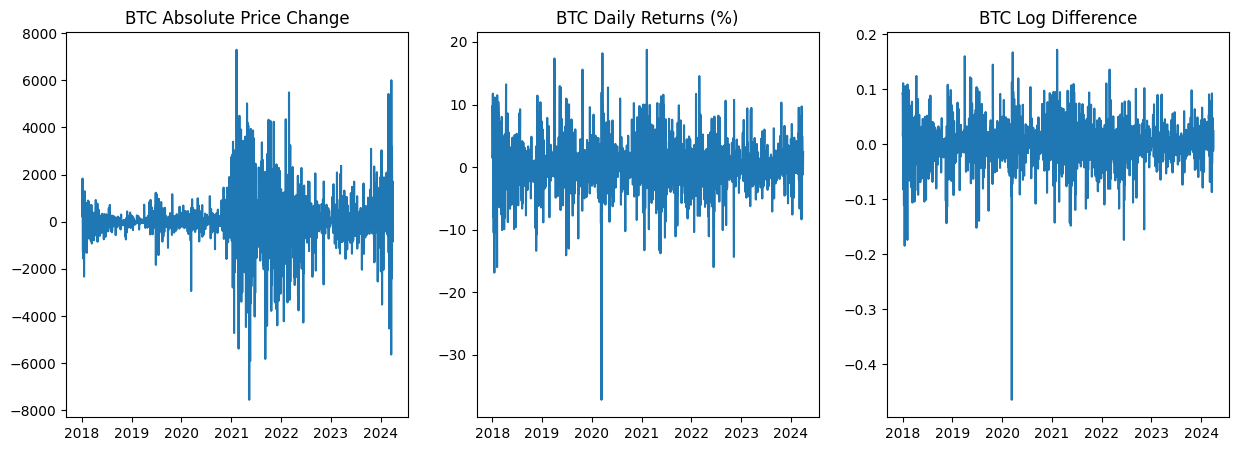

In [39]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].plot(df_final.BTC_DAILY_ABSOLUTE_CHANGE)
ax[0].set_title('BTC Absolute Price Change')
ax[1].plot(df_final.BTC_DAILY_RETURNS_PERC)
ax[1].set_title('BTC Daily Returns (%)')
ax[2].plot(df_final.BTC_LOG_DIFFERENCE)
ax[2].set_title('BTC Log Difference')
plt.show()

## Stationarity - Unit root testing

### Unit root testing

In [40]:
''' Functions for numeric data preprocessing. '''
import statsmodels.stats.api as sms

from termcolor import colored
from scipy.signal import argrelmin, argrelmax
from scipy.signal._peak_finding import _boolrelextrema
from arch.unitroot import ADF, PhillipsPerron, KPSS
from statsmodels.formula.api import ols

In [41]:
def unit_root_testing(df: pd.DataFrame, conf: float = 0.05, verbose: bool = False, tabsize: int = 30):
    ''' 
    Checks stationarity of all columns of a given pandas df using
    • Augmented Dickey-Fuller (ADF), 
    • Phillips-Perron (PP)
    • Kwiatkowski-Phillips-Schmidt-Shin (KPSS)
    unit root tests. 
    '''
    def print_result(name, p_value):
        if p_value <= conf:
            return colored(f'{p_value:.4f}', "green")  # Reject null hypothesis
        else:
            return colored(f'{p_value:.4f}', "red")    # Don't reject null hypothesis

    if verbose:
        print('ADF test:\n H0: unit root, H1: stationarity\n')
        for column in df.columns:
            p_value = np.round(ADF(df[column].dropna()).pvalue, 5)
            reject = p_value <= conf
            print(f' {column} : \tp = {print_result("ADF", p_value)} {"<" if reject else ">"} {conf} \t-> {"reject" if reject else "don`t reject"} H0 @ {100*conf}% conf.'.expandtabs(tabsize))

        print('\n------------------------------------------------------------------------------------------\n')     
        print('PP test:\n H0: unit root, H1: stationarity\n')
        for column in df.columns:
            p_value = np.round(PhillipsPerron(df[column].dropna()).pvalue, 5)
            reject = p_value <= conf
            print(f' {column} : \tp = {print_result("PP", p_value)} {"<" if reject else ">"} {conf} \t-> {"reject" if reject else "don`t reject"} H0 @ {100*conf}% conf.'.expandtabs(tabsize))

        print('\n------------------------------------------------------------------------------------------\n')     
        print('KPSS test:\n H0: stationarity, H1: unit root\n')
        for column in df.columns:
            p_value = np.round(KPSS(df[column].dropna()).pvalue, 5)
            reject = p_value > conf
            print(f' {column} : \tt = {print_result("KPSS", p_value)} {"<" if reject else ">"} {conf} \t-> {"reject" if reject else "don`t reject"} H0 @ {100*conf}% conf.'.expandtabs(tabsize))

    else:
        print('Results of ADF, PP and KPSS tests by column (p-values):\n')
        for column in df.columns:
            try:
                p_value = ADF(df[column].dropna()).pvalue
                ADF_result = print_result("ADF", p_value)
            except Exception as e:
                ADF_result = colored(type(e).__name__, "cyan")

            try:
                p_value = PhillipsPerron(df[column].dropna()).pvalue
                PP_result = print_result("PP", p_value)
            except Exception as e:
                PP_result = colored(type(e).__name__, "cyan")

            try:
                p_value = KPSS(df[column].dropna()).pvalue
                KPSS_result = print_result("KPSS", p_value)
            except Exception as e:
                KPSS_result = colored(type(e).__name__, "cyan")

            print(f'{column} --\t ADF: {ADF_result},\tPP: {PP_result},\tKPSS: {KPSS_result}'.expandtabs(tabsize))


In [42]:
# Get the columns that contain numerical data
numerical_cols = df_final.select_dtypes(include=[np.number]).columns

# Perform unit root testing on the numerical columns
unit_root_testing(df_final[numerical_cols], conf=0.05, tabsize=50)

Results of ADF, PP and KPSS tests by column (p-values):

OPEN --                                            ADF: 0.8563,                            PP: 0.9292,                              KPSS: 0.0001
HIGH --                                            ADF: 0.8544,                            PP: 0.9336,                              KPSS: 0.0001
LOW --                                             ADF: 0.8807,                            PP: 0.9384,                              KPSS: 0.0001
CLOSE --                                           ADF: 0.8719,                            PP: 0.9401,                              KPSS: 0.0001
ADJ_CLOSE --                                       ADF: 0.8719,                            PP: 0.9401,                              KPSS: 0.0001
VOLUME --                                          ADF: 0.0000,                            PP: 0.0000,                              KPSS: 0.0001
GOLD_ADJ_CLOSE --                                  ADF: 0.8965,          

c:\Users\Stamatis\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\unitroot\unitroot.py:167: RuntimeWarning: invalid value encountered in log
  llf = -nobs / 2.0 * (log(2 * pi) + log(sigma2) + 1)


CBOE_INTEREST_RATE_ADJ_CLOSE --                    ADF: 0.9116,                            PP: 0.9115,                              KPSS: 0.0001
TREASURY_YIELD_5YRS_ADJ_CLOSE --                   ADF: 0.9334,                            PP: 0.9294,                              KPSS: 0.0001
RUSSEL_2000_ADJ_CLOSE --                           ADF: 0.4338,                            PP: 0.3923,                              KPSS: 0.0001
ISHARES_20YR_ADJ_CLOSE --                          ADF: 0.8238,                            PP: 0.8003,                              KPSS: 0.0001
TREASURY_BILL_13WK_ADJ_CLOSE --                    ADF: 0.9800,                            PP: 0.9908,                              KPSS: 0.0001
RUSSEL_2000_VOLUME --                              ADF: 0.0000,                            PP: 0.0000,                              KPSS: 0.0030
ISHARES_20YR_VOLUME --                             ADF: 0.2391,                            PP: 0.0000,                            

c:\Users\Stamatis\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\unitroot\unitroot.py:167: RuntimeWarning: invalid value encountered in log
  llf = -nobs / 2.0 * (log(2 * pi) + log(sigma2) + 1)
c:\Users\Stamatis\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\unitroot\unitroot.py:167: RuntimeWarning: invalid value encountered in log
  llf = -nobs / 2.0 * (log(2 * pi) + log(sigma2) + 1)
c:\Users\Stamatis\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\unitroot\unitroot.py:167: RuntimeWarning: invalid value encountered in log
  llf = -nobs / 2.0 * (log(2 * pi) + log(sigma2) + 1)
c:\Users\Stamatis\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\unitroot\unitroot.py:167: RuntimeWarning: invalid value encountered in log
  llf = -nobs / 2.0 * (log(2 * pi) + log(sigma2) + 1)


EXTREME_GREED --                                   ADF: 0.0002,                            PP: 0.0000,                              KPSS: 0.0847
FEAR --                                            ADF: 0.0000,                            PP: 0.0000,                              KPSS: 0.0009
GREED --                                           ADF: 0.0000,                            PP: 0.0000,                              KPSS: 0.0219
NEUTRAL --                                         ADF: 0.0000,                            PP: 0.0000,                              KPSS: 0.0065
SP500_ADJUSTED --                                  ADF: 0.9534,                            PP: 0.9410,                              KPSS: 0.0001
GDP --                                             ADF: 0.8981,                            PP: 0.9879,                              KPSS: 0.0001
RGDP --                                            ADF: 0.5277,                            PP: 0.9172,                            

In [43]:
class HeskedTesting:

    TEST_NAMES = ['White', 'Breusch-Pagan', 'Goldfeld-Quandt']

    @staticmethod
    def het_tests(series: pd.Series, test: str) -> float:
        '''
        Testing for heteroskedasticity

        :param series: Univariate time series as pd.Series
        :param test: String denoting the test. One of 'white','goldfeldquandt', or 'breuschpagan'

        :return: p-value as a float.

        If the p-value is high, we accept the null hypothesis that the data is homoskedastic
        '''
        series = series.reset_index(drop=True).reset_index()
        series.columns = ['time', 'value']
        series['time'] += 1

        olsr = ols('value ~ time', series).fit()

        if test == 'White':
            _, p_value, _, _ = sms.het_white(olsr.resid, olsr.model.exog)
        elif test == 'Goldfeld-Quandt':
            _, p_value, _ = sms.het_goldfeldquandt(
                olsr.resid, olsr.model.exog, alternative='two-sided')
        else:
            _, p_value, _, _ = sms.het_breuschpagan(
                olsr.resid, olsr.model.exog)

        return p_value

    @classmethod
    def run_all_tests(cls, df: pd.DataFrame, conf: float = 0.05, tabsize: int = 30):

        print('Results of White, Breusch-Pagan and Goldfeld-Quandt tests by column (p-values):\n')

        for column in df.columns:
            p_vals = {}
            for test in cls.TEST_NAMES:
                p_value = cls.het_tests(df[column].dropna(), test)
                if p_value <= conf:
                    p_vals[test] = colored(f'{p_value:.4f}', 'red')
                else:
                    p_vals[test] = colored(f'{p_value:.4f}', 'green')

            print(
                f'{column} --\t White: {p_vals["White"]},\tBreusch-Pagan: {p_vals["Breusch-Pagan"]},\tGoldfeld-Quandt: {p_vals["Goldfeld-Quandt"]}'.expandtabs(tabsize))

In [44]:
HeskedTesting.run_all_tests(df_final[numerical_cols], conf=0.05, tabsize=58)

Results of White, Breusch-Pagan and Goldfeld-Quandt tests by column (p-values):

OPEN --                                                    White: 0.0000,                                  Breusch-Pagan: 0.0000,                           Goldfeld-Quandt: 0.0000
HIGH --                                                    White: 0.0000,                                  Breusch-Pagan: 0.0000,                           Goldfeld-Quandt: 0.0000
LOW --                                                     White: 0.0000,                                  Breusch-Pagan: 0.0000,                           Goldfeld-Quandt: 0.0000
CLOSE --                                                   White: 0.0000,                                  Breusch-Pagan: 0.0000,                           Goldfeld-Quandt: 0.0000
ADJ_CLOSE --                                               White: 0.0000,                                  Breusch-Pagan: 0.0000,                           Goldfeld-Quandt: 0.0000
VOLUME --          

In [48]:
# def log_difference_dataframe(df: pd.DataFrame, stationary_vars: list):
#     ''' 
#     Returns a dataframe where non-stationary variables are differenced once. 
#     '''
#     # Create an empty dataframe to store the differenced values
#     df_differenced = pd.DataFrame(index=df.index)

#     # Log-difference non-stationary variables
#     for column in df.columns:
#         if column not in stationary_vars:
#             # Calculate first-order log difference and append it to the dataframe
#             df_differenced[column + '_d'] = np.log(df[column].shift(1) + 0.01) - np.log(df[column] + 0.01)

#     # Keep stationary variables unchanged
#     for column in stationary_vars:
#         df_differenced[column] = df[column]

#     # Concatenate stationary variables unchanged
#     stationary_data = df[stationary_vars].copy()
#     df_differenced = pd.concat([df_differenced, stationary_data], axis=1)
    
#     return df_differenced

In [54]:
def log_difference_dataframe(df: pd.DataFrame, stationary_vars: list):
    ''' 
    Returns a dataframe where non-stationary variables are differenced once. 
    '''
    # Create an empty dataframe to store the differenced values
    df_differenced = pd.DataFrame(index=df.index)

    # Log-difference non-stationary variables
    for column in df.columns:
        if column not in stationary_vars:
            try:
                # Calculate first-order log difference and append it to the dataframe
                log_diff = np.log(df[column].shift(1) + 0.01) - np.log(df[column] + 0.01)
                df_differenced[column + '_d'] = log_diff
            except ValueError:
                # Handle invalid values (e.g., skip or replace with a default value)
                pass

    # Keep stationary variables unchanged
    for column in stationary_vars:
        df_differenced[column] = df[column]

    return df_differenced

In [55]:
btc_target_vars = [
    'BTC_DAILY_ABSOLUTE_CHANGE',
    'BTC_DAILY_RETURNS_PERC',
    'BTC_LOG_DIFFERENCE'
]

In [56]:
btc_differenced_data = log_difference_dataframe(df = df_final[numerical_cols], stationary_vars= btc_target_vars)

c:\Users\Stamatis\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Stamatis\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Stamatis\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Stamatis\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Stamatis\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = ge

In [51]:
btc_differenced_data.head()

,OPEN_d,HIGH_d,LOW_d,CLOSE_d,ADJ_CLOSE_d,VOLUME_d,GOLD_ADJ_CLOSE_d,SILVER_ADJ_CLOSE_d,OIL_ADJ_CLOSE_d,GOLD_VOLUME_d,SILVER_VOLUME_d,OIL_VOLUME_d,EUR_USD_ADJ_CLOSE_d,USD_JPY_ADJ_CLOSE_d,GBP_USD_ADJ_CLOSE_d,USD_CNY_ADJ_CLOSE_d,VIX_ADJ_CLOSE_d,CBOE_INTEREST_RATE_ADJ_CLOSE_d,TREASURY_YIELD_5YRS_ADJ_CLOSE_d,RUSSEL_2000_ADJ_CLOSE_d,ISHARES_20YR_ADJ_CLOSE_d,TREASURY_BILL_13WK_ADJ_CLOSE_d,RUSSEL_2000_VOLUME_d,ISHARES_20YR_VOLUME_d,TESLA_ADJ_CLOSE_d,AMD_ADJ_CLOSE_d,INTEL_ADJ_CLOSE_d,APPLE_ADJ_CLOSE_d,NVIDIA_ADJ_CLOSE_d,META_ADJ_CLOSE_d,GOOGLE_ADJ_CLOSE_d,TESLA_VOLUME_d,AMD_VOLUME_d,INTEL_VOLUME_d,APPLE_VOLUME_d,NVIDIA_VOLUME_d,META_VOLUME_d,GOOGLE_VOLUME_d,GBTC_ADJ_CLOSE_d,ARKB_ADJ_CLOSE_d,BITB_ADJ_CLOSE_d,FBTC_ADJ_CLOSE_d,BTCO_ADJ_CLOSE_d,IBIT_ADJ_CLOSE_d,HODL_ADJ_CLOSE_d,BITO_ADJ_CLOSE_d,GBTC_VOLUME_d,ARKB_VOLUME_d,BITB_VOLUME_d,FBTC_VOLUME_d,BTCO_VOLUME_d,IBIT_VOLUME_d,HODL_VOLUME_d,BITO_VOLUME_d,ETH_ADJ_CLOSE_d,ETH_VOLUME_d,USDT_ADJ_CLOSE_d,USDT_VOLUME_d,USDC_ADJ_CLOSE_d,USDC_VOLUME_d,DOGE_ADJ_CLOSE_d,DOGE_VOLUME_d,XRP_ADJ_CLOSE_d,XRP_VOLUME_d,SOL_ADJ_CLOSE_d,SOL_VOLUME_d,GAS_ADJ_CLOSE_d,GAS_VOLUME_d,GAS_USD_d,EXTREME_FEAR_d,EXTREME_GREED_d,FEAR_d,GREED_d,NEUTRAL_d,SP500_ADJUSTED_d,GDP_d,RGDP_d,UNRATE_d,CPI_d,INTEREST_RATE_ADJUSTED_d,TREASURE_MATURITY_ADJUSTED_d,INFLATION_RATE_ADJUSTED_d,STICKY_CPI_d,M2_MONEY_STOCK_ADJUSTED_d,VOLUME_ADI_d,VOLUME_OBV_d,VOLUME_CMF_d,VOLUME_FI_d,VOLUME_EM_d,VOLUME_SMA_EM_d,VOLUME_VPT_d,VOLUME_VWAP_d,VOLUME_MFI_d,VOLUME_NVI_d,VOLATILITY_BBM_d,VOLATILITY_BBH_d,VOLATILITY_BBL_d,VOLATILITY_BBW_d,VOLATILITY_BBP_d,VOLATILITY_BBHI_d,VOLATILITY_BBLI_d,VOLATILITY_KCC_d,VOLATILITY_KCH_d,VOLATILITY_KCL_d,VOLATILITY_KCW_d,VOLATILITY_KCP_d,VOLATILITY_KCHI_d,VOLATILITY_KCLI_d,VOLATILITY_DCL_d,VOLATILITY_DCH_d,VOLATILITY_DCM_d,VOLATILITY_DCW_d,VOLATILITY_DCP_d,VOLATILITY_ATR_d,VOLATILITY_UI_d,TREND_MACD_d,TREND_MACD_SIGNAL_d,TREND_MACD_DIFF_d,TREND_SMA_FAST_d,TREND_SMA_SLOW_d,TREND_EMA_FAST_d,TREND_EMA_SLOW_d,TREND_VORTEX_IND_POS_d,TREND_VORTEX_IND_NEG_d,TREND_VORTEX_IND_DIFF_d,TREND_TRIX_d,TREND_MASS_INDEX_d,TREND_DPO_d,TREND_KST_d,TREND_KST_SIG_d,TREND_KST_DIFF_d,TREND_ICHIMOKU_CONV_d,TREND_ICHIMOKU_BASE_d,TREND_ICHIMOKU_A_d,TREND_ICHIMOKU_B_d,TREND_STC_d,TREND_ADX_d,TREND_ADX_POS_d,TREND_ADX_NEG_d,TREND_CCI_d,TREND_VISUAL_ICHIMOKU_A_d,TREND_VISUAL_ICHIMOKU_B_d,TREND_AROON_UP_d,TREND_AROON_DOWN_d,TREND_AROON_IND_d,TREND_PSAR_UP_d,TREND_PSAR_DOWN_d,TREND_PSAR_UP_INDICATOR_d,TREND_PSAR_DOWN_INDICATOR_d,MOMENTUM_RSI_d,MOMENTUM_STOCH_RSI_d,MOMENTUM_STOCH_RSI_K_d,MOMENTUM_STOCH_RSI_D_d,MOMENTUM_TSI_d,MOMENTUM_UO_d,MOMENTUM_STOCH_d,MOMENTUM_STOCH_SIGNAL_d,MOMENTUM_WR_d,MOMENTUM_AO_d,MOMENTUM_ROC_d,MOMENTUM_PPO_d,MOMENTUM_PPO_SIGNAL_d,MOMENTUM_PPO_HIST_d,MOMENTUM_PVO_d,MOMENTUM_PVO_SIGNAL_d,MOMENTUM_PVO_HIST_d,MOMENTUM_KAMA_d,OTHERS_DR_d,OTHERS_DLR_d,OTHERS_CR_d,UNIQUE_USERS_d,FOLLOWERS_d,TWEET_COUNT_d,BTC_PERCENTAGE_DOMINANCE_d,ETH_PERCENTAGE_DOMINANCE_d,USDT_PERCENTAGE_DOMINANCE_d,BNB_PERCENTAGE_DOMINANCE_d,SOL_PERCENTAGE_DOMINANCE_d,OTHERS_PERCENTAGE_DOMINANCE_d,GPR_d,GPRT_d,GPRA_d,GPRH_d,GPRHT_d,GPRHA_d,SHARE_GPR_d,N10_d,SHARE_GPRH_d,N3H_d,GPRH_NOEW_d,GPR_NOEW_d,GPRH_AND_d,GPR_AND_d,GPRH_BASIC_d,GPR_BASIC_d,SHAREH_CAT_1_d,SHAREH_CAT_2_d,SHAREH_CAT_3_d,SHAREH_CAT_4_d,SHAREH_CAT_5_d,SHAREH_CAT_6_d,SHAREH_CAT_7_d,SHAREH_CAT_8_d,GPRC_ARG_d,GPRC_AUS_d,GPRC_BEL_d,GPRC_BRA_d,GPRC_CAN_d,GPRC_CHE_d,GPRC_CHL_d,GPRC_CHN_d,GPRC_COL_d,GPRC_DEU_d,GPRC_DNK_d,GPRC_EGY_d,GPRC_ESP_d,GPRC_FIN_d,GPRC_FRA_d,GPRC_GBR_d,GPRC_HKG_d,GPRC_HUN_d,GPRC_IDN_d,GPRC_IND_d,GPRC_ISR_d,GPRC_ITA_d,GPRC_JPN_d,GPRC_KOR_d,GPRC_MEX_d,GPRC_MYS_d,GPRC_NLD_d,GPRC_NOR_d,GPRC_PER_d,GPRC_PHL_d,GPRC_POL_d,GPRC_PRT_d,GPRC_RUS_d,GPRC_SAU_d,GPRC_SWE_d,GPRC_THA_d,GPRC_TUN_d,GPRC_TUR_d,GPRC_TWN_d,GPRC_UKR_d,GPRC_USA_d,GPRC_VEN_d,GPRC_VNM_d,GPRC_ZAF_d,GPRHC_ARG_d,GPRHC_AUS_d,GPRHC_BEL_d,GPRHC_BRA_d,GPRHC_CAN_d,GPRHC_CHE_d,GPRHC_CHL_d,GPRHC_CHN_d,GPRHC_COL_d,GPRHC_DEU_d,GPRHC_DNK_d,GPRHC_EGY_d,GPRHC_ESP_d,GPRHC_FIN_d,GPRHC_FRA_d,GPRHC_GBR_d,GPRHC_HKG_d,GPRHC_HUN_d,GPRHC

In [53]:
HeskedTesting.run_all_tests(btc_differenced_data, conf=0.5, tabsize=60)

Results of White, Breusch-Pagan and Goldfeld-Quandt tests by column (p-values):

OPEN_d --                                                    White: 0.0017,                                    Breusch-Pagan: 0.0005,                             Goldfeld-Quandt: 0.0000
HIGH_d --                                                    White: 0.0002,                                    Breusch-Pagan: 0.0000,                             Goldfeld-Quandt: 0.0000
LOW_d --                                                     White: 0.0040,                                    Breusch-Pagan: 0.0012,                             Goldfeld-Quandt: 0.0000
CLOSE_d --                                                   White: 0.0022,                                    Breusch-Pagan: 0.0006,                             Goldfeld-Quandt: 0.0000
ADJ_CLOSE_d --                                               White: 0.0022,                                    Breusch-Pagan: 0.0006,                             Goldfeld-Quan

ValueError: zero-size array to reduction operation maximum which has no identity